# Convex-hull Approximation Test

## This might be usefull if depth contours are not possible to be computed

In some cases if depth contours can't be computed from a given data point, due to the sparsity or the points being on a full convex hypersurface (specially in higher dimension hence not triagularizable), the process described in this notebook might be a way to compute the depth contours. For example, let's say we have a set of data points $\mathbf{F}$ that are very sparse or all the points in $\mathbf{F}$ are on a convex surface, therefore, `simple_shape.depth_contours()` function fails.

To solve this problem, we construct a similar surface $\mathbf{R}$ by random sampling, such that $|\mathbf{R}| \sim |\mathbf{F}|$. Find its depth contours $\mathcal{d}_{\mathbf{R}}(p): p \in \mathbf{R} \rightarrow \mathbb{Z}$. Assuming randomly sampled points can be triangularized. Now for each point $p \in \mathbf{R}$, find the closest point $p \in \mathbf{F}$ to construct a depth contours of $\mathbf{F}$, $\mathcal{d}_{\mathbf{F}}(p): p \in \mathbf{F} \rightarrow \mathbb{Z}$.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

### Function to generate $\mathbf{R}$

In [2]:
import numpy as np
sys.path.append('../')
from vis.generators import dtlz2
from vis.generators import c2dtlz2
from vis.generators import c0dtlz2

def generate_r(F, frontname, verbose=False):
    n = {'dtlz2': F.shape[0], 'c2dtlz2': 210000, 'c0dtlz2': 5000}
    
    LB, UB = np.mean(np.min(F, axis=0)), np.mean(np.max(F, axis=0))
    r = UB - LB
    if frontname == 'dtlz2':
        R, _ = dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c2dtlz2':
        R, _, _ = c2dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c0dtlz2':
        R, _, _ = c0dtlz2.surface(r=r, n=n[frontname], m=F.shape[1])
    else:
        raise ValueError("PF generation function for {:s} is not supported.".format(frontname))

    # check
    if verbose:
        print("F.shape =", F.shape)
        print("R.shape =", R.shape)
    
    return R

### An L2-norm based $\mathcal{d}_{\mathbf{F}}(\cdot)$ approximation function

In [3]:
import os
import numpy as np
sys.path.append('../')
from vis.tda import simple_shape
from vis.utils import io

def approximate_depth_l2norm(F, frontname, save_ref_depth=False, verbose=False):
    # Generate a random data points that are on the same surface as F.
    # These points are R
    R = generate_r(F, frontname, verbose=verbose)
    
    # Now find depth contours from R
    if verbose:
        print("Computing depth contours of", pf)
    Dr = simple_shape.depth_contours(R, verbose=verbose)

    # Save in a temp file
    if save_ref_depth:
        drfname = frontname + "-r-depth-cont-cvhull.csv"
        drfpath = os.path.join("/tmp", drfname)
        io.savetxt(drfpath, Dr, fmt='{:d}', delimiter=',')
    
    # Find depth contour of F from that of R
    Dr_ = Dr[::-1]
    Id = np.arange(0,F.shape[0]).astype(int)
    Df = []
    while Id.shape[0] > 0:
        # for each layer l in d_R
        for l in Dr_:
            s = []
            # for each index i in l
            for i in l.astype(int):
                # find the point j in F that is closest to R[i]
                if Id.shape[0] > 0:
                    j = np.argmin(np.linalg.norm(F[Id]-R[i], axis=1))
                    s.append(Id[j])
                    Id = np.delete(Id, j)
                else:
                    break
            if len(s) > 0:
                Df.append(np.array(s).astype(int))
    Df = np.array(Df, dtype=object)
    Df = Df[::-1]
    
    # print and check counts
    if verbose:
        print("Df.shape[0] =", Df.shape[0])
        s = 0
        for i,l in enumerate(Df):
            print("Df[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

        print("Dr.shape[0] =", Dr.shape[0])
        s = 0
        for i,l in enumerate(Dr):
            print("Dr[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

    return R,Dr,Df

### Find depth contours on the failed cases

F.shape = (3432, 8)
R.shape = (3432, 8)
Computing depth contours of dtlz2-nbi
Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Computing depth contour 3 ...
Computing depth contour 4 ...
Df.shape[0] = 5
Df[0].shape[0] = 1639
Df[1].shape[0] = 1076
Df[2].shape[0] = 528
Df[3].shape[0] = 168
Df[4].shape[0] = 21
total = 3432
Dr.shape[0] = 5
Dr[0].shape[0] = 1639
Dr[1].shape[0] = 1076
Dr[2].shape[0] = 528
Dr[3].shape[0] = 168
Dr[4].shape[0] = 21
total = 3432
Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


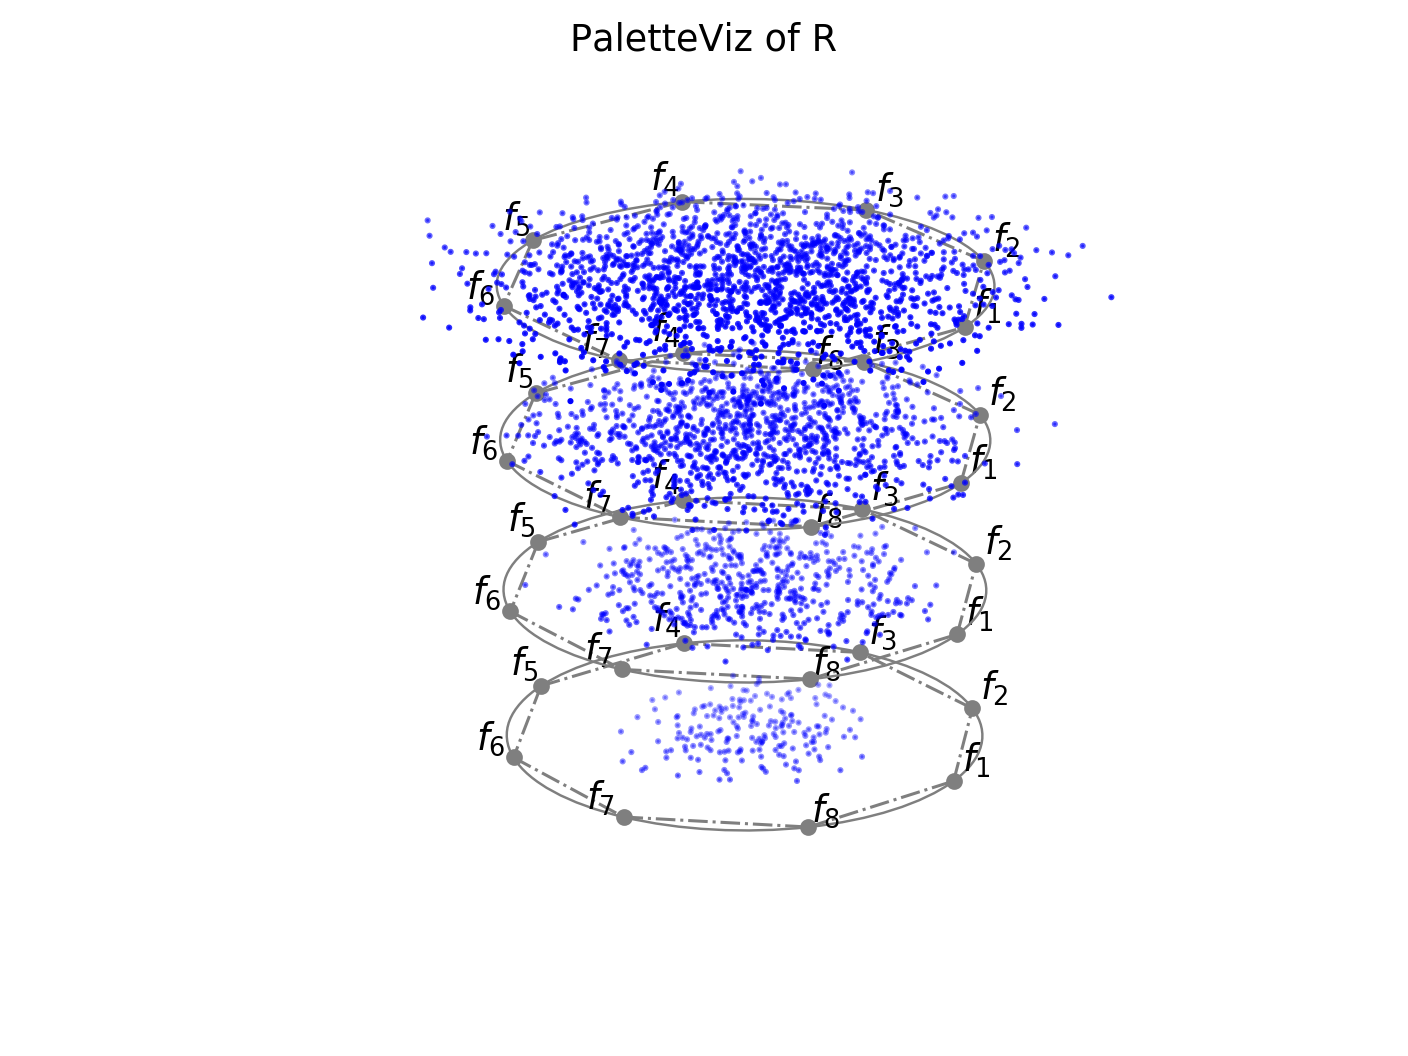

Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


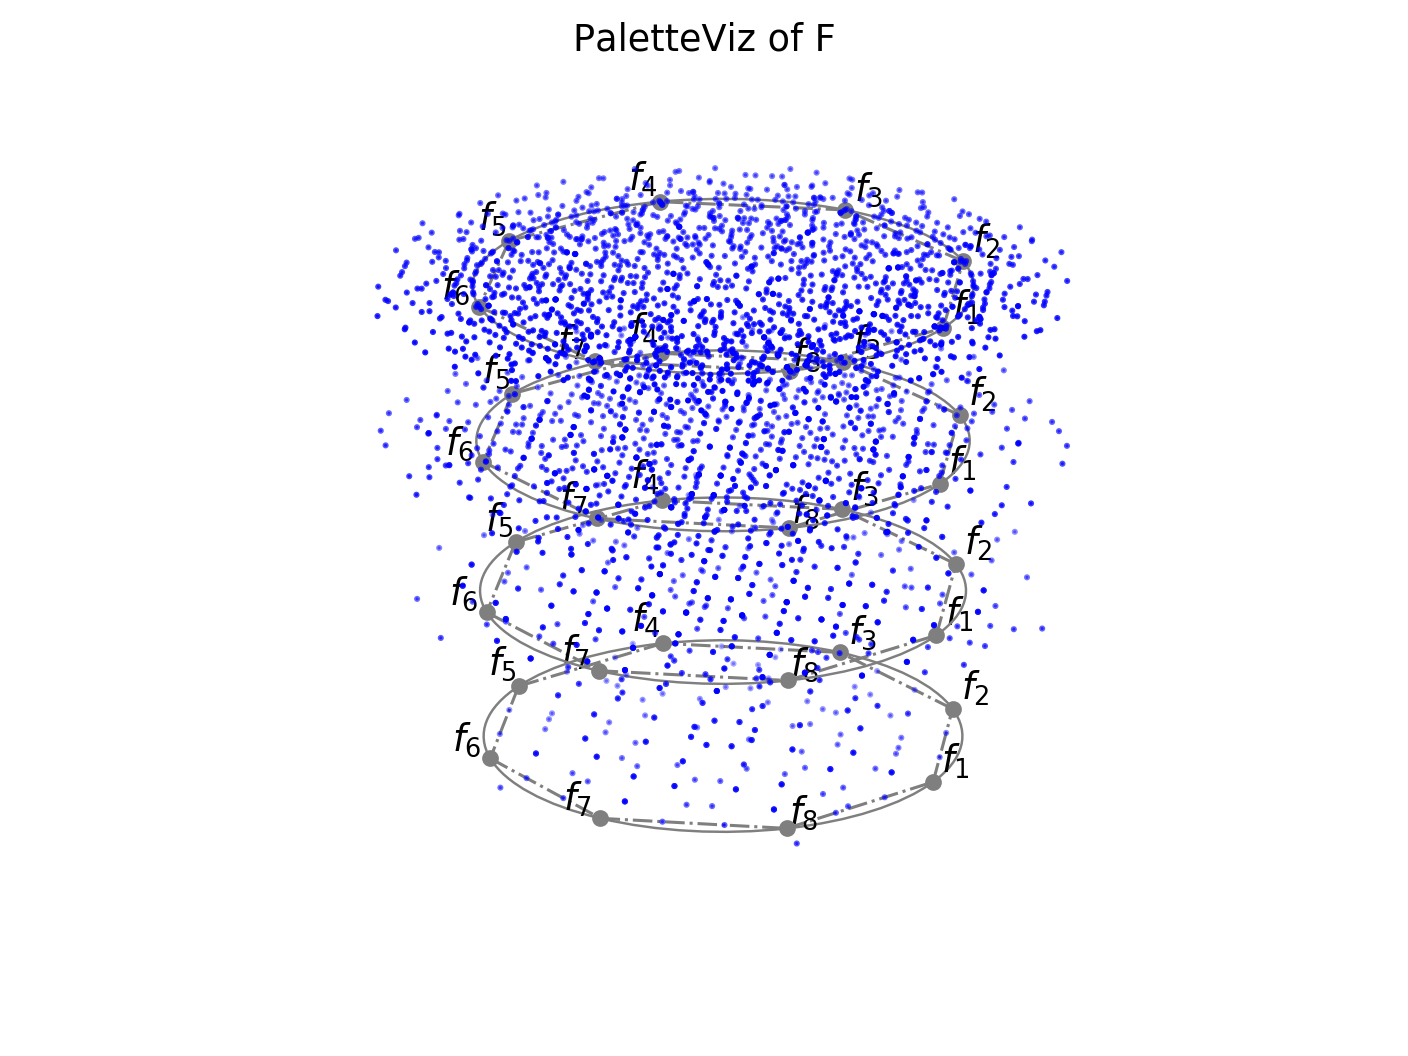

F.shape = (3872, 8)
R.shape = (3933, 8)
Computing depth contours of c2dtlz2-nbi
Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Computing depth contour 3 ...
Computing depth contour 4 ...
Df.shape[0] = 6
Df[0].shape[0] = 58
Df[1].shape[0] = 2228
Df[2].shape[0] = 1129
Df[3].shape[0] = 382
Df[4].shape[0] = 72
Df[5].shape[0] = 3
total = 3872
Dr.shape[0] = 6
Dr[0].shape[0] = 119
Dr[1].shape[0] = 2228
Dr[2].shape[0] = 1129
Dr[3].shape[0] = 382
Dr[4].shape[0] = 72
Dr[5].shape[0] = 3
total = 3933
Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


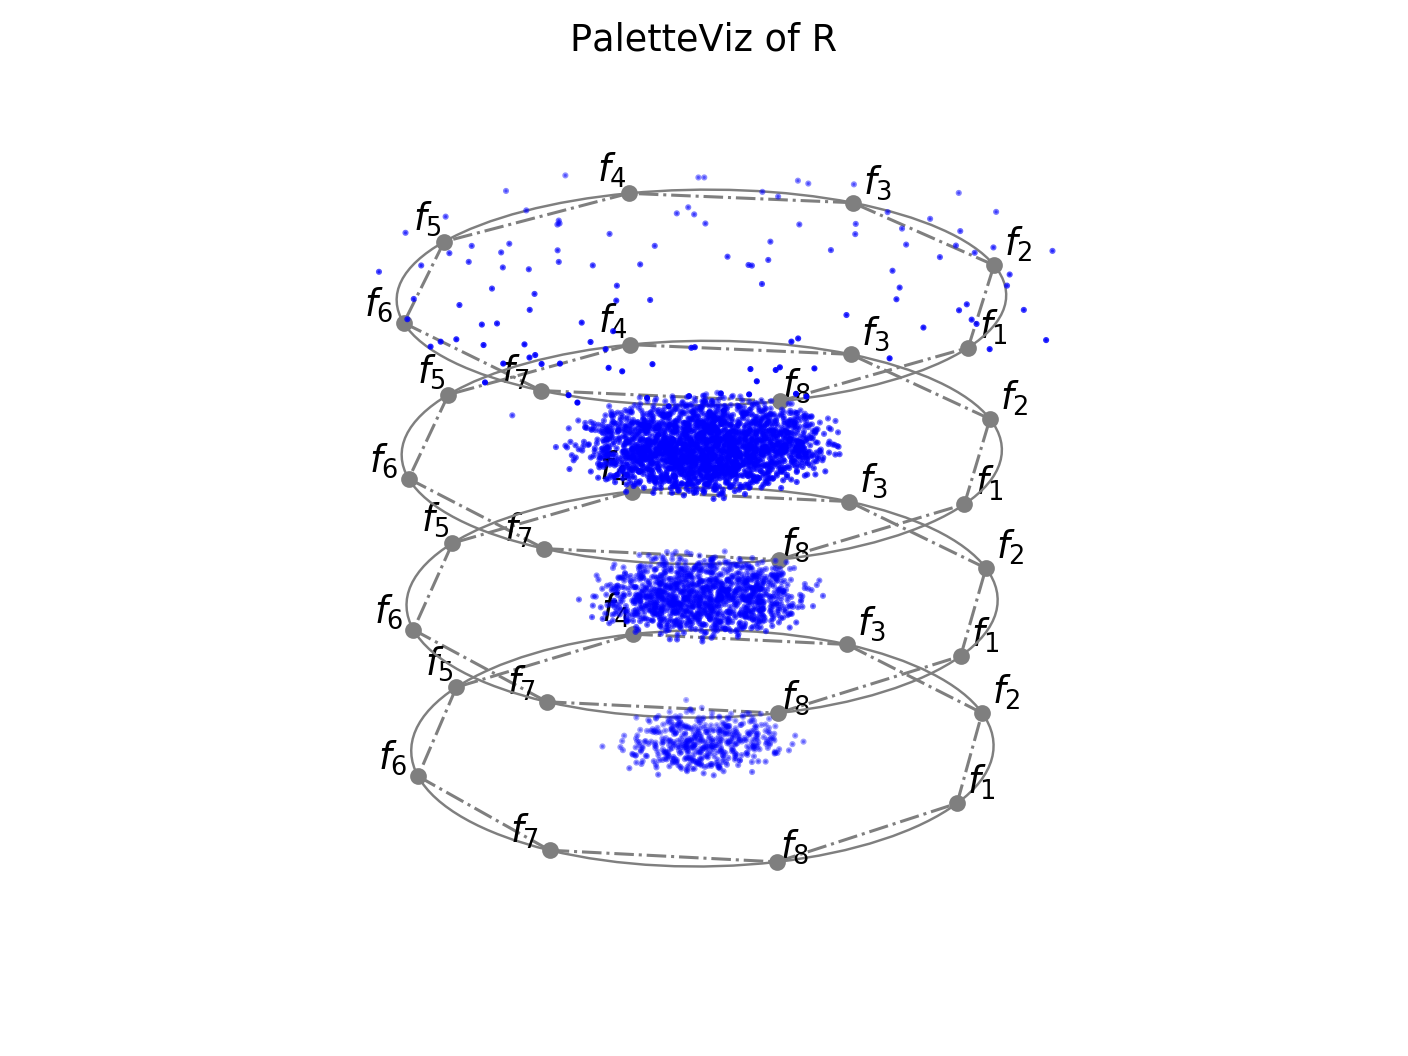

Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


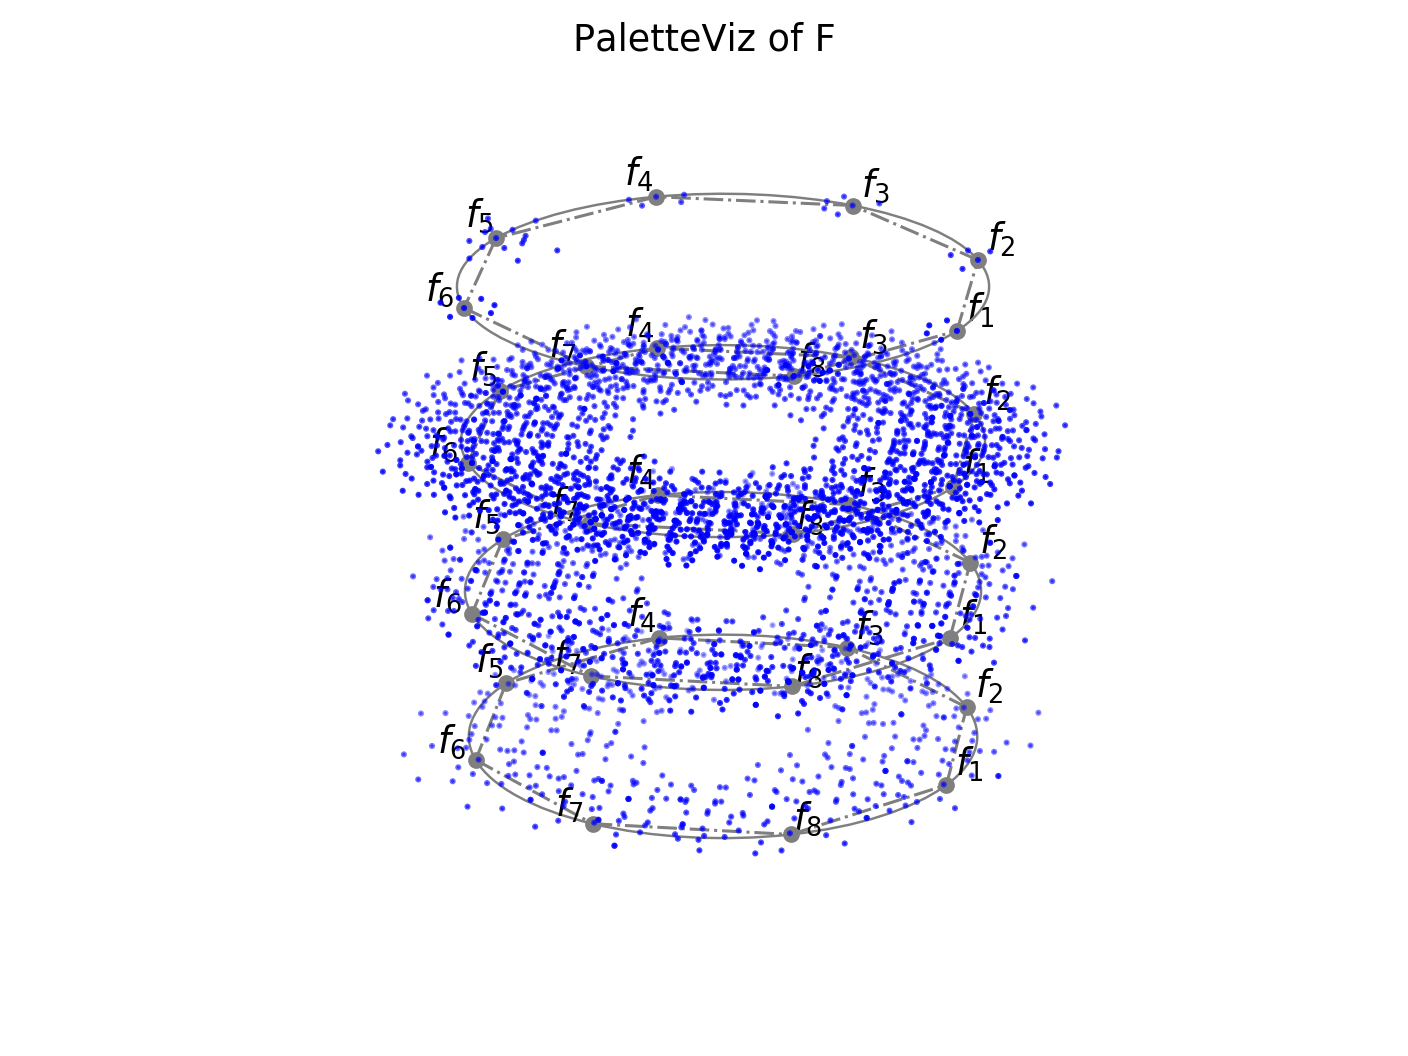

F.shape = (3180, 8)
R.shape = (3337, 8)
Computing depth contours of c0dtlz2-nbi
Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Df.shape[0] = 4
Df[0].shape[0] = 2436
Df[1].shape[0] = 659
Df[2].shape[0] = 84
Df[3].shape[0] = 1
total = 3180
Dr.shape[0] = 4
Dr[0].shape[0] = 2593
Dr[1].shape[0] = 659
Dr[2].shape[0] = 84
Dr[3].shape[0] = 1
total = 3337
Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


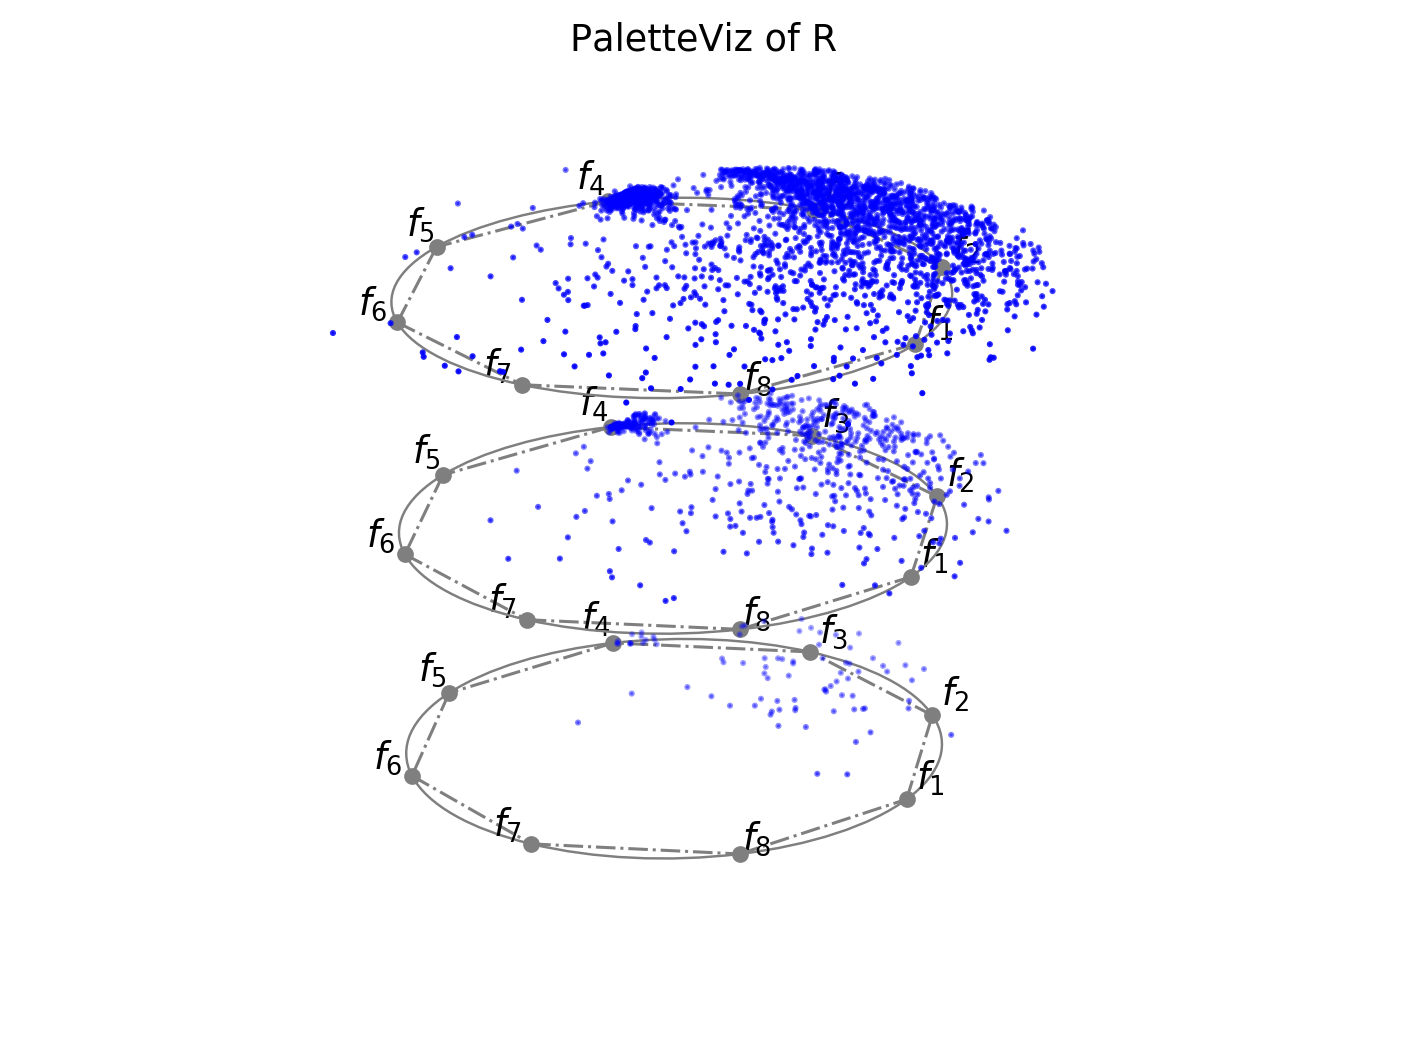

Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


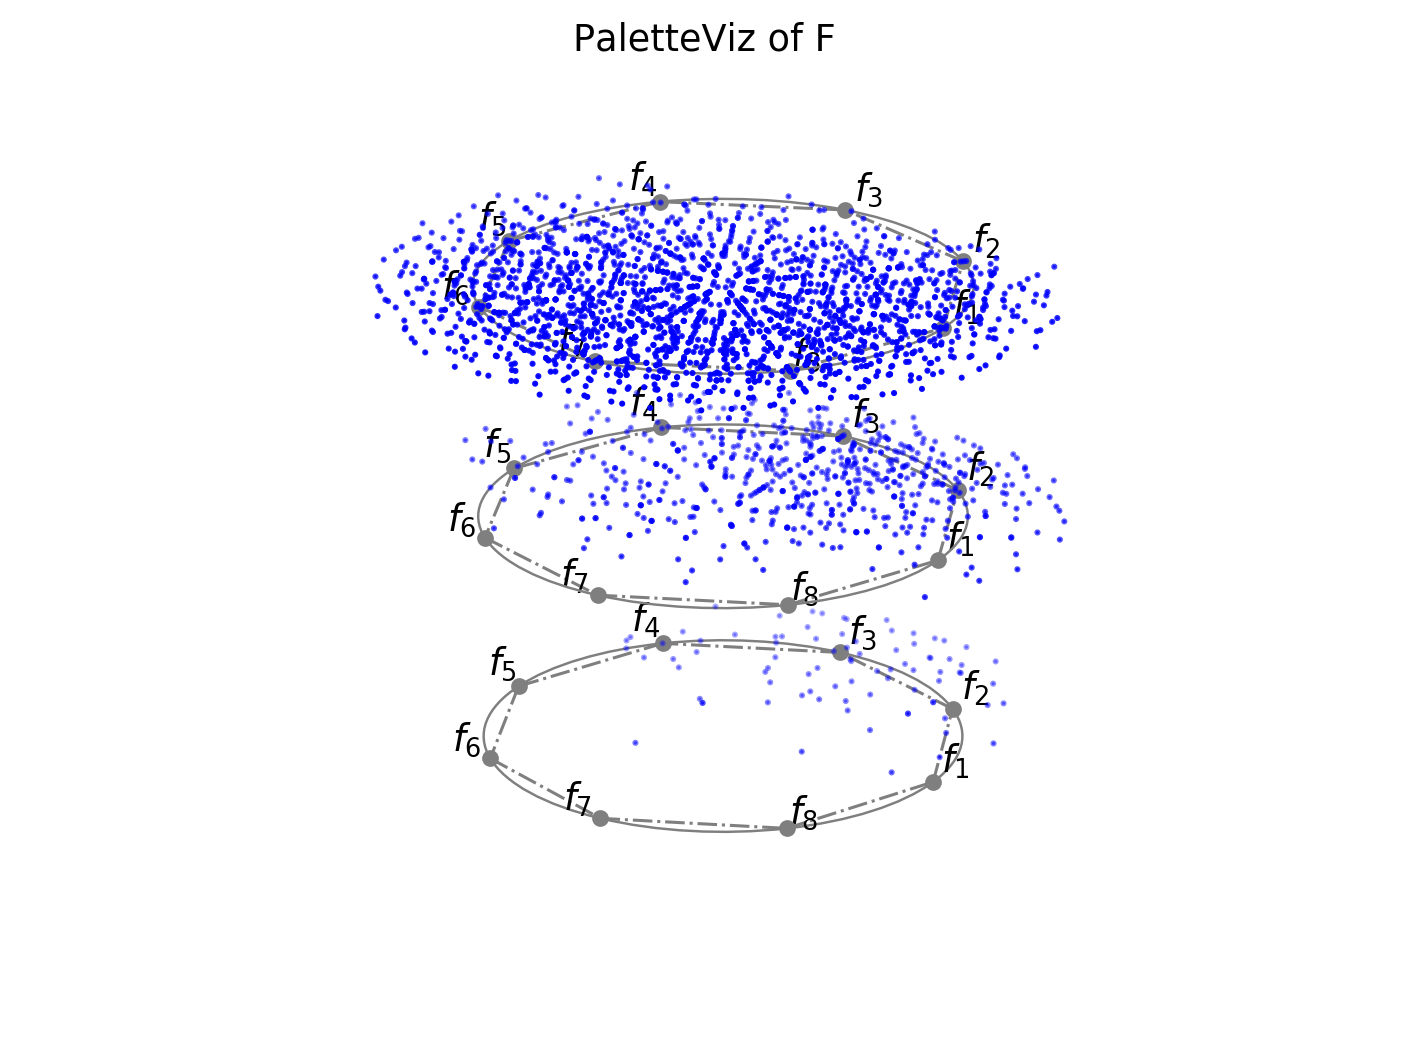

In [4]:
sys.path.append('../')
from vis.utils import io
from vis.plotting import paletteviz

# Data where the depth contours were not 
# possible to compute, these are F's.
failed = {'dtlz2-nbi': ['8d'], 'c2dtlz2-nbi': ['8d'], 'c0dtlz2-nbi': ['8d']}

for pf in list(failed.keys()):
    for dim in failed[pf]:
        fpath = "../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        path, _ = os.path.split(fpath)
        dirs = path.split('/')
        frontname = dirs[-2].split('-')[0]

        F = np.loadtxt(fpath, delimiter=',')
        
        # Approximate depth contours of F from R
        R,Dr,Df = approximate_depth_l2norm(F, frontname, verbose=True, save_ref_depth=True)

        # plot and verify
        paletteviz.plot(R, plt=plt, depth_contours=Dr, mode='star', \
                        n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of R")
        plt.show()
                
        # plot and verify
        paletteviz.plot(F, plt=plt, depth_contours=Df, mode='star', \
                        n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of F")
        plt.show()

        # save the layers
        io.savetxt(os.path.join(path, "depth-cont-cvhull.csv"), Df, fmt='{:d}', delimiter=',')